# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - amenities pois
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to calculate the distance from the orginal node of a sample point to the nearest pois (in this case, it is shop with supermarket and convenience stores). The accessibility score is integrated into the sample point dataframe based on the node id, the accessibility score is then transformed into a dummy variable with 1 as shops within 1km of the original nodes of samples points, and 0 as shops beyond 1km distance.

### Process:
1. Download or load points of interest (POIs) from OSM
2. Load the OSM graphml and create network via Pandana
3. Calculate accessibility to the amenity pois we retrieved from OSM.
    - the output results are the distance of orginal nodes to the nearest pois
4. connect the accessibility score to sample point dataframe
    - accessibility score is calculated as 1=distance to the nearest pois are within 1000km; 0=distance to the nearest pois are beyond 1000km



In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import os
import time 

from osmnx import log

import pandana
from pandana.loaders import osm

ox.config(use_cache=True, log_console=True)
pandana.__path__

['/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana']

## Set up configuration 

In [52]:
place = 'phoenix' 

region = 'Arizona, USA' # study region name

studyregion = 'Phoenix, Arizona, USA'

suffix = '_201905'

# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
shop = ['supermarket', 'convenience']

# configure filenames to save/load POI and network datasets
OSM_folder = '../data/OSM'

# configure projected network graph
G_filename = 'Phoenix, Arizona, USA_walk_201905.graphml'
poi_filename = '{}_pois_{}.csv'.format(place, '_'.join(shop))


G_filepath = OSM_folder + "/" + G_filename
poi_filepath = OSM_folder + "/" + poi_filename
sample_points_filepath = '../data/OSM/phoenix_sample_points_stats_201905.csv'

In [53]:
# get bounding box from study region boundary shapefile
shape_filepath = '../data/OSM/Phoenix, Arizona, USA_buffered_201905/Phoenix, Arizona, USA_buffered_201905.shp'

gdf_shape = gpd.GeoDataFrame.from_file(shape_filepath)
bbox = [gdf_shape['bbox_south'].astype(float)[0], gdf_shape['bbox_west'].astype(float)[0], gdf_shape['bbox_north'].astype(float)[0], gdf_shape['bbox_east'].astype(float)[0]] #lat-long bounding box for Phx
bbox

[33.2903739, -112.3240289, 33.9183794, -111.9255201]

In [54]:
# configure search at a max distance of 1 km for up to the 2 nearest points-of-interest
distance = 1000
num_pois = 2
num_categories = len(shop) + 1 #one for each amenity, plus one extra for all of them combined

In [55]:
# keyword arguments to pass for the matplotlib figure
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10)}


# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

## Download points of interest (POIs) from OSM
What amenities are considered for daily living pois? - [OSMtag](https://taginfo.openstreetmap.org/keys/amenity): shop=supermarket, convenience

In [56]:
def get_osm_pois(poi_filepath=poi_filepath, shop=shop, bbox=bbox):
    if os.path.isfile(poi_filepath):
        # if a points-of-interest file already exists, just load the dataset from that
        pois = pd.read_csv(poi_filepath)
        method = 'loaded from CSV'
    else:   
        # otherwise, query the OSM API for the specified amenities within the bounding box 
        osm_tags = '"shop"~"{}"'.format('|'.join(shop))
        pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)

        # drop any that aren't just 'shop' then save to CSV
        pois = pois[pois['shop'].isin(shop)]
        pois.to_csv(poi_filepath, index=False, encoding='utf-8')
        method = 'downloaded from OSM'
    pois_df = pois[['shop', 'name', 'lat', 'lon']]
    return pois_df
    

In [57]:
pois_df = get_osm_pois(poi_filepath=poi_filepath, shop=shop, bbox=bbox)
pois_df.head()

,shop,name,lat,lon
0,supermarket,Safeway,33.488551,-112.081794
1,convenience,7-Eleven,33.480013,-112.029747
2,supermarket,Fry's Marketplace,33.321899,-111.930303
3,supermarket,Fry's Food & Drug,33.379098,-111.976857
4,convenience,NaN,33.348719,-111.953919


## Load the OSM graphml and create network via Pandana

Reference:
[gdf node and edge attribute](https://automating-gis-processes.github.io/2018/notebooks/L6/network-analysis.html)  
[Pandana Network function](https://udst.github.io/pandana/tutorial.html)  
** Pandana is agnostic to the coordinate system. Use your local coordinate system or longitude then latitude - either one will work. (in this example, we use network graph with local coordinate system (unprojected))


In [59]:
def get_pandana_network(G_filename, folder, bbox=None):
    start_time = time.time()
    if os.path.isfile(folder + "/" + G_filename):
        method = 'loaded from graphml'
        G_osm_walk = ox.load_graphml(G_filename, folder)
        # get gdf nodes and edges
        gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
        gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
        # get network from Pandana
        network=pandana.network.Network(gdf_osm_walk_nodes["x"], gdf_osm_walk_nodes["y"], gdf_osm_walk_edges["u"], gdf_osm_walk_edges["v"],
                 gdf_osm_walk_edges[["length"]])
    
    else:
        method = 'downloaded from OSM'
        # otherwise, query the OSM API for the street network within the bounding box
        G_osm_walk = ox.graph_from_bbox(north=bbox[2], south=bbox[0], east=bbox[3], west=bbox[1], network_type= 'walk', retain_all=True, buffer_dist=1e4)
        # get gdf nodes and edges
        gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
        gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    
        # get network from Pandana
        network=pandana.network.Network(gdf_osm_walk_nodes["x"], gdf_osm_walk_nodes["y"], gdf_osm_walk_edges["u"], gdf_osm_walk_edges["v"],
                 gdf_osm_walk_edges[["length"]])
    log('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))
    return network  

In [60]:
network = get_pandana_network(G_filename=G_filename, folder=OSM_folder, bbox=bbox)

/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


## Calculate accessibility to the amenity we retrieved

** make sure the loaded network is the same project as the pois dataframe

In [61]:
def get_nearest_poi_to_node(pandana_network, pois_df, distance, num_pois):
    # precomputes the range queries (the reachable nodes within this maximum distance)
    # so, as long as you use a smaller distance, cached results will be used
    network.precompute(distance + 1)
    
    # initialize a category for all amenities with the locations specified by the lon and lat columns
    network.set_pois(category='all', maxdist=distance, maxitems=num_pois, x_col=pois_df['lon'], y_col=pois_df['lat'])

    # searches for the n nearest amenities (of all types) to each node in the network
    all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

    # it returned a df with the number of columns equal to the number of POIs that are requested
    # each cell represents the network distance from the node to each of the n POIs
    log('{:,} nodes'.format(len(all_access)))
    return all_access

In [62]:
all_access = get_nearest_poi_to_node(pandana_network=network, pois_df=pois_df, distance=distance, num_pois=num_pois)
all_access.head()

/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


,1,2
41190548,1000.0,1000.0
41190554,1000.0,1000.0
41190577,1000.0,1000.0
41190578,1000.0,1000.0
41190580,1000.0,1000.0


Ideas: for indicator calculation, we could count whether the nearest POIs are located within certain search distance to the nodes. (This approach use the hard distance thredshold approach)[https://3.basecamp.com/3662734/buckets/11779922/messages/1813713976 ]

### Plot accessibility from each node to any amenity

Text(0.5,1,'Walking distance (1000m) to nearest supermarket and convenience shops, phoenix')

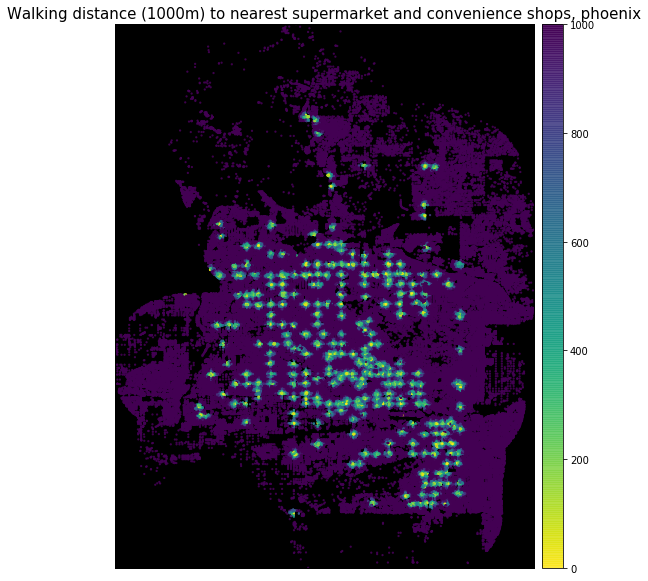

In [18]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance ({}m) to {}, {}'.format(distance, shop, studyregion), fontsize=15)
#fig.savefig('images/accessibility-shop-phx.png', dpi=200, bbox_inches='tight')

## Integrate the accessibility score in sample point dataframe

In [65]:
# keep nodes with the nearest (first) pois within 1 km 
nodes_pois_1km = all_access[all_access[1] < 1000][[1]]

In [66]:
# load previously saved sample point dataframe
sample_points_stats = pd.read_csv(sample_points_filepath)
sample_points_stats.columns

Index(['Unnamed: 0', 'index', 'Series', 'access', 'area', 'bridge', 'highway',
       'junction', 'key', 'lanes', 'length', 'maxspeed', 'name', 'oneway',
       'osmid', 'ref', 'service', 'tunnel', 'u', 'v', 'width', 'points',
       'geometry', 'area_km', 'intct_count', 'intct_den', 'node_dist',
       'node_id'],
      dtype='object')

In [67]:
# merge to get the accessibility distance
sample_points_stats.node_id = sample_points_stats.node_id.astype(int)
sample_points_stats = pd.merge(left=sample_points_stats, right=nodes_pois_1km, how='left', left_on='node_id', right_index=True)

In [68]:
sample_points_stats = sample_points_stats.rename(columns={1:'nearest_shop_1km'})
#fill none value as 0 indicating that the nearest shop is not within 1km of the nodes/sample point
#fill values morethan 0 as 1 indicating that the nearest shop is within 1km of the nodes/sample point
sample_points_stats['nearest_shop_1km'] = sample_points_stats['nearest_shop_1km'].fillna(0) 
sample_points_stats.loc[sample_points_stats['nearest_shop_1km'] > 0, 'nearest_shop_1km'] = 1
sample_points_stats.head()

,Unnamed: 0,index,Series,access,area,bridge,highway,junction,key,lanes,...,v,width,points,geometry,area_km,intct_count,intct_den,node_dist,node_id,nearest_shop_1km
0,0,0,POINT (399320.4111184602 3704054.876976978),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772851,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399320.4111184602 3704054.876976978),3.776545,406,107.505682,18094.224675,41797604,1.0
1,1,0,POINT (399294.9269077833 3704055.126239192),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772851,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399294.9269077833 3704055.126239192),4.653264,544,116.907177,35275.866267,1604511752,0.0
2,2,0,POINT (399269.4426971063 3704055.375501406),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772851,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399269.4426971063 3704055.375501406),3.349992,319,95.224102,24521.116301,5634577087,0.0
3,3,1,POINT (399320.4111184602 3704054.876976978),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772854,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399320.4111184602 3704054.876976978),3.776545,406,107.505682,18094.224675,41797604,1.0
4,4,1,POINT (399337.8713994289 3704054.705951796),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772854,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399337.8713994289 3704054.705951796),3.556236,349,98.137475,4233.820519,2926772436,1.0


In [69]:
sample_points_stats.shape

(100, 29)